In [1]:
#!pip install healpy

import healpy as hp
from healpy.newvisufunc import projview
from healpy.visufunc import cartview, mollview

import os
import json
import shutil
import numpy as np
import pandas as pd
import numpy.ma as ma
from functools import partial
import matplotlib.pyplot as plt

In [2]:
def write_json(target_path, target_file, data):
    if not os.path.exists(target_path):
        try:
            os.makedirs(target_path)
        except Exception as e:
            print(e)
            raise
    with open(os.path.join(target_path, target_file), 'w') as f:
        json.dump(data, f)

def intt(num):
    num = int(num + (0.5 if num > 0 else -0.5))
    return num

Сonfig with observatory data, including FOV of telescopes, number of iterations and latitude, longitude allowed for observations

In [3]:
config = {"day": 1,
"annotations": [
{"observatory_name": "observatory_1",
 "frame_longitude": 1,
 "frame_latitude": 1,
 "iteration": 60,
 "border_longitude": [80,240],
 "border_latitude": [-40,90]},
 {"observatory_name": "observatory_2",
 "frame_longitude": 2,
 "frame_latitude": 2,
 "iteration": 40,
 "border_longitude": [240,90],
 "border_latitude": [-40,90]},
 {"observatory_name": "observatory_3",
 "frame_longitude": 1,
 "frame_latitude": 1,
 "iteration": 130,
 "border_longitude": [120,240],
 "border_latitude": [-70,60]},
 {"observatory_name": "observatory_4",
 "frame_longitude": 1,
 "frame_latitude": 1,
 "iteration": 100,
 "border_longitude": [200,20],
 "border_latitude": [-40,90]}
]
}

In [4]:
#####
root_dir = '/content/drive/MyDrive/Colab Notebooks/IKI projects/Data/Scanning/2nd' # Event folder path
orig_file_name = 'S200302c.fits.gz' # HEALPix file name in folder
#####

decay = 0.9 # Decay FOV coeff
sky_area = int(4 * 180**2 / np.pi) + 1
d_ang_y = 180
d_ang_x = 360
file_name = 'cur_hpx'
day = config['day']
if day==1:
  shutil.copyfile(os.path.join(root_dir, orig_file_name), os.path.join(root_dir, file_name))
hpx = hp.read_map(os.path.join(root_dir, file_name))
npix = len(hpx)
nside = hp.pixelfunc.get_nside(hpx)

matrix_ang = [] # Create RA DEC list of HEALPix
for i in range(len(hpx)):
  cur_val = hpx[i]
  theta, phi = hp.pix2ang(nside, i)
  ra = np.rad2deg(phi)
  dec = np.rad2deg(0.5 * np.pi - theta)
  matrix_ang.append([dec, ra])

Original HEALPix in mollweide projection

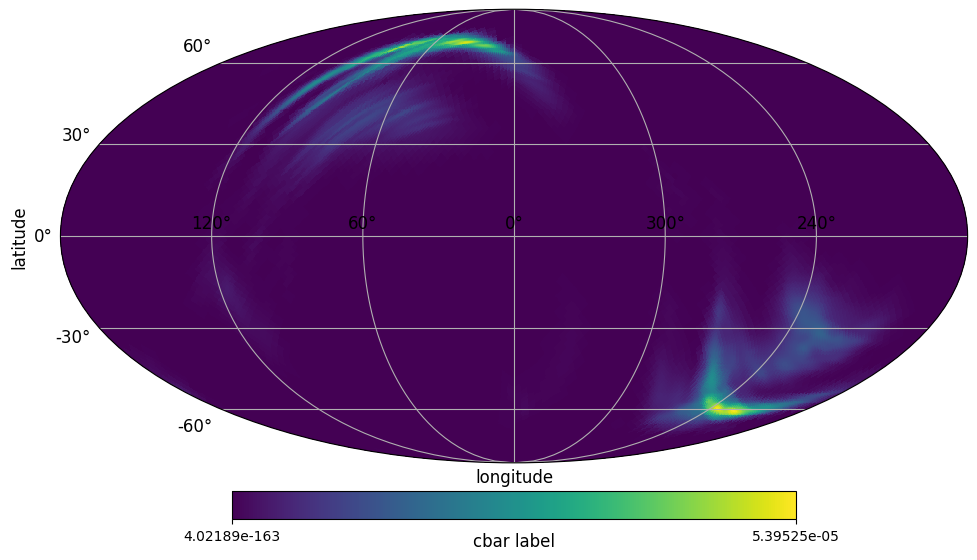

In [5]:
projview(
    hp.read_map(os.path.join(root_dir, orig_file_name)),
    coord=["G"],
    width = 10,
    graticule=True,
    graticule_labels=True,
    unit="cbar label",
    xlabel="longitude",
    ylabel="latitude",
    cb_orientation="horizontal",
    projection_type="mollweide"
);

Сalculation of traversal order for a given observatory (include borders in latitude and longitude, max_step between iterations) is based on the quality matrix:
\begin{equation}
    arr_{quality}[i][j] = \alpha * arr[i][j] - \beta * f(i,j,x_1, y_1)
\end{equation} Where
$f(...)$ - distance between $(i,j)$ and $(x_1, y_1)$ pixels,

$arr$ - cartesian projection of HEALPix with variable axes,

$alpha$ & $beta$ - coefficients

In [6]:
def cur_matrix(arr, y_n, x_n, scale_x, scale_y, alpha=10**(5), beta=10**(-2), max_step = 5):
  """
  Сurrent quality matrix for a 'simple' algorithm
  """
  cur_arr = np.zeros_like(arr)
  bord1 = [int(y_n-max_step) if int(y_n-max_step)>0 else 0][0]
  bord2 = [int(y_n+max_step) if int(y_n+max_step)<scale_y else int(scale_y)][0]
  for i in range(bord1,bord2):
    for j in range(scale_x):
      dist_y = abs(y_n-i)
      abs_x = abs(x_n-j)
      dist_x = [abs_x if (abs_x<=(scale_x/2)) else (scale_x-abs_x)][0]
      if dist_x > max_step:
        cur_arr[i][j] = 0
      else:
        cur_arr[i][j] = (alpha*arr[i][j]) - (beta*(dist_y**2 + dist_x**2)**0.5)
  return cur_arr

def simple(arr, i, scale_x, scale_y):
  """
  Algorithm for finding the next iteration and writing current iteration
  """
  report = []
  pred_xy = []
  y_n, x_n = np.unravel_index(np.argmax(arr), arr.shape)
  val_n = arr[y_n][x_n]
  report = [y_n, x_n, f'{int(val_n)}%']
  arr[y_n][x_n] = 0
  pred_xy.append(report)
  for z in range(i-1):
    cur_arr = cur_matrix(arr, y_n, x_n, scale_x, scale_y) 
    y_n, x_n = np.unravel_index(np.argmax(cur_arr), cur_arr.shape)
    val_n = arr[y_n][x_n]
    report = [y_n, x_n, f'{int(val_n)}%']
    arr[y_n][x_n] = 0
    pred_xy.append(report)
  return pred_xy

def transition_xy(pred_xy, scale_x, scale_y):
  """
  Cartesian coordinates to RA DEC coordinates
  """
  for i in range(len(pred_xy)):
    cur_y = pred_xy[i][0] + 0.5
    cur_x = pred_xy[i][1] + 0.5
    pred_xy[i][0] = round(((d_ang_y/scale_y)*cur_y) - (d_ang_y/2), 2)
    pred_xy[i][1] = round(( ((d_ang_x/scale_x)*(scale_x-cur_x)) + (d_ang_x/2))%d_ang_x, 2)
  return pred_xy

In [7]:
def mollweide(draw):
  if draw==True:
    projview(
      hpx,
      coord=["G"],
      title=f'{observatory_name} with {iteration} iter and borders long: {border_longitude}, lat: {border_latitude}',
      width = 10,
      graticule=True,
      graticule_labels=True,
      unit="cbar label",
      xlabel="longitude",
      ylabel="latitude",
      cb_orientation="horizontal",
      projection_type="mollweide"
    );
  return

def rewrite_hpx(hpx, matrix_ang, pred_ang, frame_x, frame_y):
  """
  Rewriting of the HEALPix taking into account the passed frames (passed frames = pred_ang)
  """
  for j in range(len(hpx)):
    theta, phi = matrix_ang[j]
    for i in range(len(pred_ang)):
      my_theta, my_phi, trash = pred_ang[i]
      if (my_theta-((1/decay)*frame_y/2) < theta < my_theta+((1/decay)*frame_y/2)) and (my_phi-((1/decay)*frame_x/2) < phi < my_phi+((1/decay)*frame_x/2)):
        hpx[j] = 0
  hp.write_map(os.path.join(root_dir, file_name), hpx, overwrite=True)
  return  hpx

In [8]:
def get_list(hpx, file_name, day, matrix_ang, observatory_name, frame_x, frame_y, scale_x, scale_y, iteration, border_long, border_lat):
  proj = hp.projector.CartesianProj(hpx, xsize=scale_x, ysize=scale_y)
  map = proj.projmap(map=hpx, vec2pix_func=partial(hp.vec2pix, nside)) # Get projection of current HEALPix
  arr = map.copy()
  mx = np.amax(arr)
  arr = (arr/mx)*100 # Rescale

  for i in range(arr.shape[0]): # Consider borders of current observatory
    for j in range(arr.shape[1]):
      if i<border_lat[0] or i>border_lat[1]:
        arr[i][j] = 0
      if (border_long[0]>border_long[1]) and (j>border_long[0] or j<border_long[1]):
        arr[i][j] = 0
      if (border_long[0]<border_long[1]) and (border_long[0]<j<border_long[1]):
        arr[i][j] = 0
  
  pred_xy = []
  pred_ang = []
  pred_xy = simple(arr, iteration, scale_x, scale_y)  # Make a list of target for current observatory
  pred_ang = transition_xy(pred_xy, scale_x, scale_y) 
  day = f"{day}_day"
  write_json(os.path.join(root_dir, day), observatory_name+'.txt', pred_ang)

  beta = 1/decay
  hpx = rewrite_hpx(hpx, matrix_ang, pred_ang, frame_x, frame_y)
  mollweide(True)
  return

Mollweide projection of intermediate results for each observatory from the config (all zero areas are areas transmitted for telescopes)

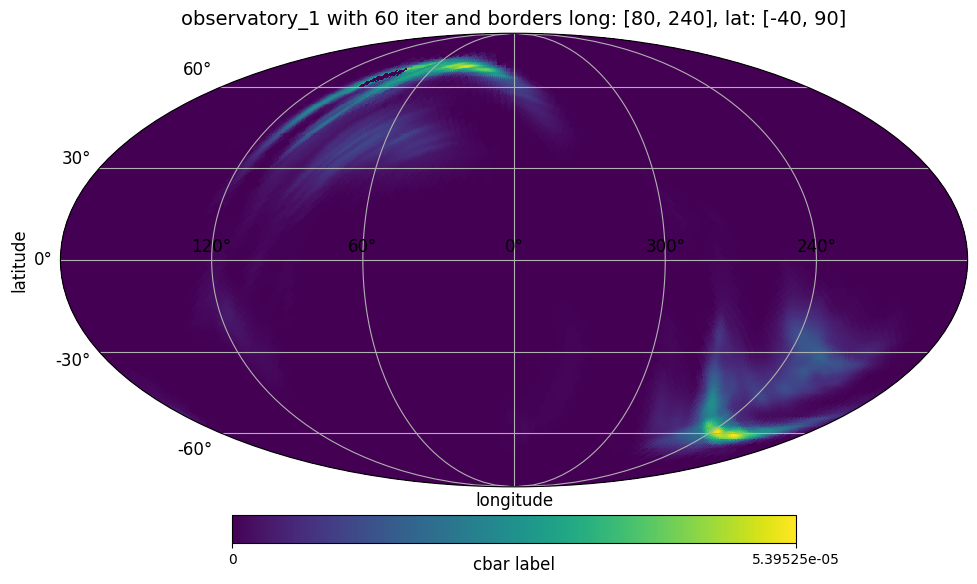

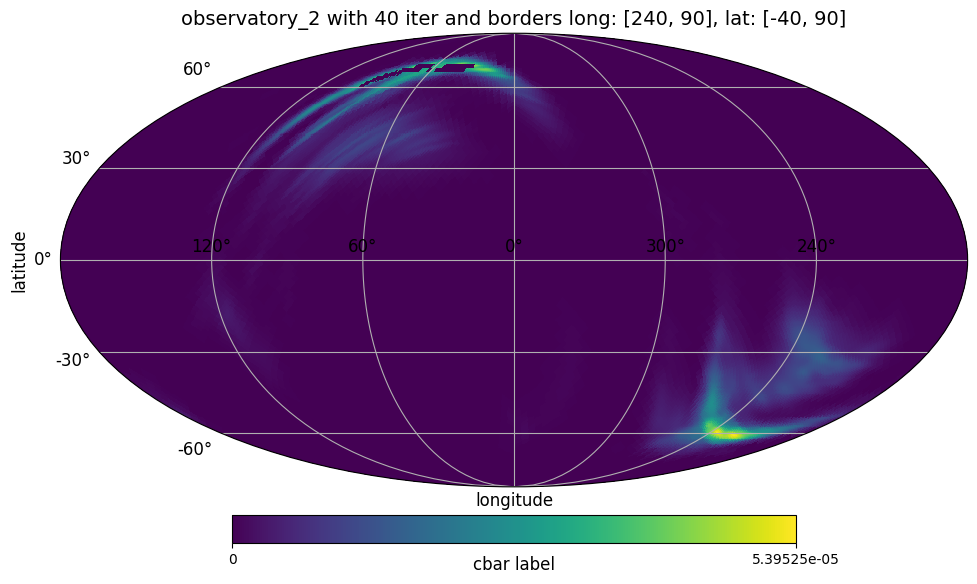

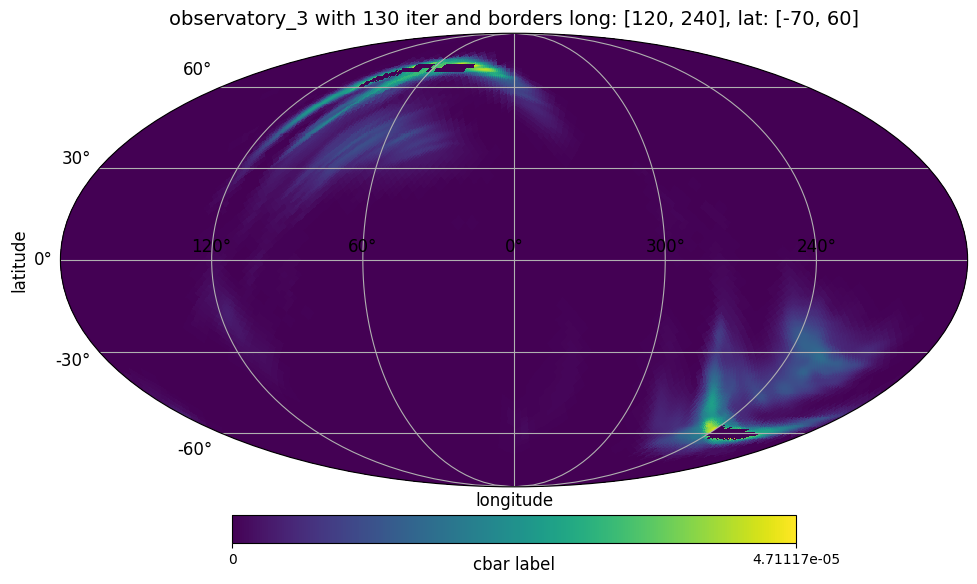

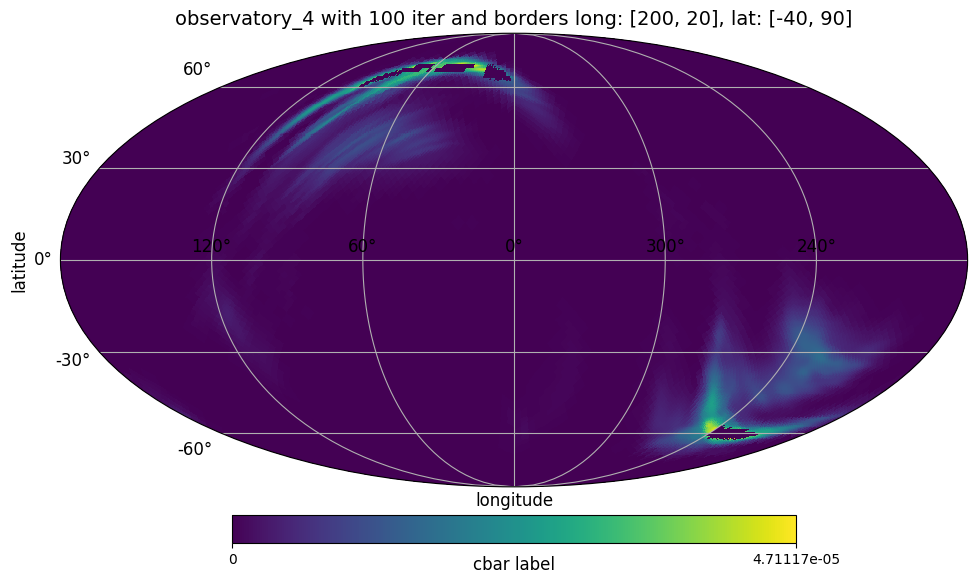

In [9]:
for i in range(len(config['annotations'])):
    observatory_name = config['annotations'][i]['observatory_name']
    frame_longitude = config['annotations'][i]['frame_longitude']
    frame_latitude = config['annotations'][i]['frame_latitude']
    frame_x = decay*frame_longitude
    scale_x = d_ang_x/frame_x
    scale_x = intt(scale_x)
    frame_y = decay*frame_latitude
    scale_y = d_ang_y/frame_y
    scale_y = intt(scale_y)

    iteration = config['annotations'][i]['iteration']
    iteration = config['annotations'][i]['iteration']
    border_longitude = config['annotations'][i]['border_longitude']
    border_latitude = config['annotations'][i]['border_latitude']
    border_lat = np.empty_like(border_latitude)
    border_long = np.empty_like(border_longitude)
    border_lat[0] = (border_latitude[0]+(d_ang_y/2))*scale_y/d_ang_y
    border_lat[1] = (border_latitude[1]+(d_ang_y/2))*scale_y/d_ang_y
    border_long[0] = [-((border_longitude[0]-(d_ang_x/2))*scale_x/d_ang_x) if border_longitude[0]<(d_ang_x/2) else scale_x-((border_longitude[0]-(d_ang_x/2))*scale_x/d_ang_x)][0]
    border_long[1] = [-((border_longitude[1]-(d_ang_x/2))*scale_x/d_ang_x) if border_longitude[1]<(d_ang_x/2) else scale_x-((border_longitude[1]-(d_ang_x/2))*scale_x/d_ang_x)][0]

    day = day
    hpx = hp.read_map(os.path.join(root_dir, file_name))
    get_list(hpx, file_name, day, matrix_ang, observatory_name, frame_x, frame_y, scale_x, scale_y, iteration, border_long, border_lat)